In [1]:
%config IPCompleter.greedy=True

In [2]:
import constants
from utils.file_utils import load_pickle_from_disk
import pandas as pd
import numpy as np
import os
import re
import openslide
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
def create_preds_array(slide_name):
    slide_to_dims = load_pickle_from_disk(f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/slide_name_to_tile_dims_map")
    dims = slide_to_dims[slide_name]
    preds_array = np.full(dims, fill_value=np.nan, dtype=np.float32)
    
    preds_file = f"{constants.PREDICTIONS_DIRECTORY}/{slide_name}.csv"
    df = pd.read_csv(preds_file)
    patch_to_coords = load_pickle_from_disk(f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/patch_name_to_coords_map")
    coords_list = []
    
    for _, row in df.iterrows():
        coords = patch_to_coords[row['filepath'].replace('.jpg', '')]
        preds_array[coords] = row['prediction']
        coords_list.append(coords)
    
    return preds_array, coords_list, dims, df
    

In [4]:
def get_confusion_matrix(slide, preds_df):
    confusion_mat = np.zeros((2, 2), dtype=np.int32)

    for _,row in preds_df.iterrows():
        pred = int(round(row['prediction']))
        confusion_mat[row['labels'], pred] +=1

    return confusion_mat

#

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """
    Pretty print for confusion matrices
    from https://gist.github.com/zachguo/10296432
    """
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth

    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "

    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES

    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")

    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [5]:
def knn_smooth(preds_array, coords, knn_range=1, smooth_factor=0.7):
    result_array = np.copy(preds_array)
    
    for c in coords:
        x, y = c
        adj = preds_array[max(x-knn_range, 0):x+knn_range+1, max(y-knn_range,0):y+knn_range+1]
        if smooth_factor != 1:
            weights = np.invert(np.isnan(adj)) * smooth_factor
            weights[knn_range, knn_range] = 1
            result_array[c] = np.nansum(adj * weights) / np.sum(weights)
        else:
            result_array[c] = np.nanmean(adj)
    
    return result_array

In [6]:
def estimate_surface_areas(preds_array, label_to_class):
    class_preds = preds_array.round()
    n_classes = 2
    num_per_class = defaultdict(int)
    
    
    for label in range(int(n_classes)):
        num_per_class[label_to_class[label]] = np.sum(class_preds == label)
    
    patch_area = constants.PATCH_SIZE ** 2
    sa_per_class = {c:n*patch_area for c,n in num_per_class.items()}
        
    return num_per_class, sa_per_class
    

In [7]:
def get_sa_for_slide(slide_name):
    path = f"{constants.SA_CSV_DIRECTORY}/{slide_name}.csv"
    sa_df = pd.read_csv(path)
    sa_df.columns = ['class', 'area']
    sa_by_class = sa_df.groupby('class').sum()
    sa_dict = defaultdict(int)
    
    for class_name, val in sa_by_class.iterrows():
        area = val[0]
        sa_dict[class_name] = area
    
    return sa_dict

In [8]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_predictions(preds_array, slide, label_to_class, dims, mode='jupyter'):
    path = get_slide_path(slide)
    slide_obj = openslide.OpenSlide(path)
    im = slide_obj.get_thumbnail((dims[1], dims[0])).resize((dims[1], dims[0]))
    dpi = 100
    dims_in = (dims[0] / dpi, dims[1] / dpi)
    
    fig = plt.figure(figsize=dims_in, dpi=dpi)
    ax = plt.gca()
    ax.imshow(im, alpha=0.7)
    arr = ax.imshow(preds_array, interpolation='none', cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.5)
    ax.set_title(f"{slide} Classification Confidences")
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(arr, ticks=[0.0, 0.5, 1.0], cax=cax)
    cbar.set_ticklabels([process_label(label_to_class[0]), '', process_label(label_to_class[1])])
    
    if mode == 'jupyter':
        plt.show()
        plt.close()
        
    elif mode == 'save':
        viz_dir = f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/visualizations"
        if not os.path.isdir(viz_dir):
            os.makedirs(viz_dir)
        plt.savefig(f"{viz_dir}/{slide}.png")
        plt.close()
    
def process_label(label):
    return label.replace("_"," ").title()

def get_slide_path(slide):
    if "Scan" in slide:
        path = f"{constants.SLIDE_FILE_DIRECTORY}/" + "/".join(slide.split("_")) + f"/{slide}.qptiff"
    else:
        prefix = re.split("[0-9]+", slide)[0]
        img_num = int(re.findall("[0-9]+", slide)[0])

        path = f"{constants.SLIDE_FILE_DIRECTORY}/{prefix}{img_num:02}/{slide}.svs"
    return path

In [9]:
def get_metrics(num_per_class, sa_dict, preds_array, class_to_label):
    total_num = sum(list(num_per_class.values()))

    true_ls_ratio = sa_dict['large_tumor'] / (sa_dict['large_tumor'] + sa_dict['small_tumor'])
    pred_ls_ratio = num_per_class['large_tumor'] / (num_per_class['large_tumor'] + num_per_class['small_tumor'])

    print(f"Predicted Large-Small Ratio: {pred_ls_ratio:.2f}; True ratio: {true_ls_ratio:.2f}")

    return true_ls_ratio, pred_ls_ratio

In [10]:
def process_predictions(slide):
    preds_array, coords, dims, df = create_preds_array(slide)
    if constants.KNN_SMOOTH:
        preds_array = knn_smooth(preds_array, coords)

    class_to_label = load_pickle_from_disk(f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/class_to_label")
    label_to_class = {v:k for k,v in class_to_label.items()}
    
    confusion_matrix = get_confusion_matrix(slide, df)
    print_cm(confusion_matrix, labels = [label_to_class[i] for i in range(max(label_to_class.keys()) + 1)])
    print()

    num_per_class, sa_per_class = estimate_surface_areas(preds_array, label_to_class)

    visualize_predictions(preds_array, slide, label_to_class, dims)

    sa_dict = get_sa_for_slide(slide)
    true, pred = get_metrics(num_per_class, sa_dict, preds_array, class_to_label)
    
    return true, pred, confusion_matrix

In [11]:
def process_all_predictions():
    confusion_mat = np.zeros((2, 2), dtype=np.int32)
    df = pd.DataFrame(columns=['slide', 'predicted_ratio', 'true_ratio'])
    
    for slide_file in os.listdir(constants.PREDICTIONS_DIRECTORY):
        slide = slide_file.replace(".csv", "")
        print(f"Results for Slide {slide}")
        true, pred, confuse = process_predictions(slide)
        
        confusion_mat += confuse
        df = df.append({'slide':slide, 'predicted_ratio':pred, 'true_ratio':true}, ignore_index=True)
        
    df.to_csv(os.path.join(constants.PREDICTIONS_DIRECTORY, "predicted_ratios.csv"))
    
    print("Final Confusion Matrix")
    print()
    print_cm(confusion_mat, labels = [label_to_class[i] for i in range(max(label_to_class.keys()) + 1)])

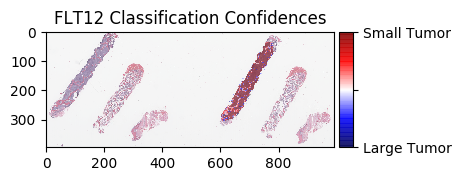

Results for class Large Tumor:
Predicted ratio: 0.15; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.85; True ratio: 0.00; Mean Confidence: 0.84


defaultdict(<function __main__.get_metrics.<locals>.<lambda>()>,
            {'large_tumor': {'true': 1.0, 'pred': 0.15305883272130635},
             'small_tumor': {'true': 0.0, 'pred': 0.8469411672786936}})

In [11]:
slide = 'FLT12'
process_predictions(slide)

Results for Slide FLT12


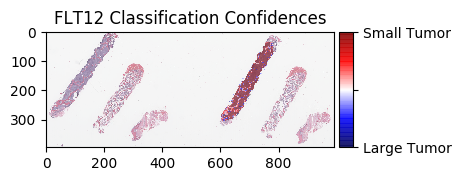

Results for class Large Tumor:
Predicted ratio: 0.15; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.85; True ratio: 0.00; Mean Confidence: 0.84
Results for Slide FLT6


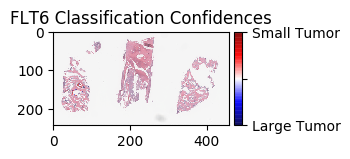

Results for class Large Tumor:
Predicted ratio: 0.46; True ratio: 0.23
Results for class Small Tumor:
Predicted ratio: 0.54; True ratio: 0.77; Mean Confidence: 0.51
Results for Slide FLT8


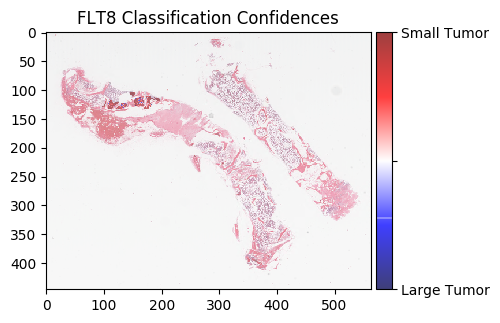

Results for class Large Tumor:
Predicted ratio: 0.11; True ratio: 0.90
Results for class Small Tumor:
Predicted ratio: 0.89; True ratio: 0.10; Mean Confidence: 0.81
Results for Slide FLN07_Scan1


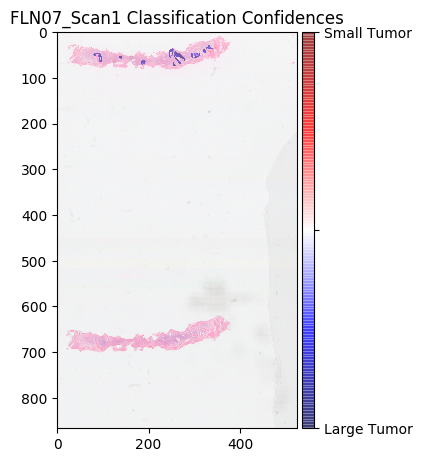

Results for class Large Tumor:
Predicted ratio: 0.96; True ratio: 0.00
Results for class Small Tumor:
Predicted ratio: 0.04; True ratio: 1.00; Mean Confidence: 0.19
Results for Slide FLT01_Scan3


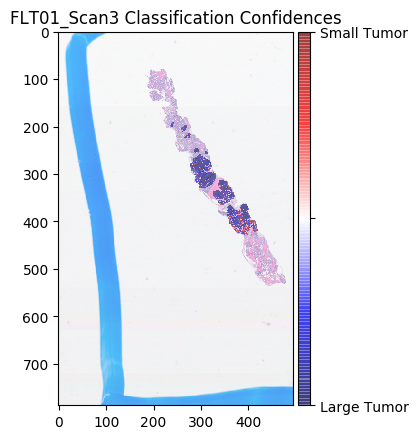

Results for class Large Tumor:
Predicted ratio: 0.85; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.15; True ratio: 0.00; Mean Confidence: 0.20
Results for Slide FLT03_Scan1


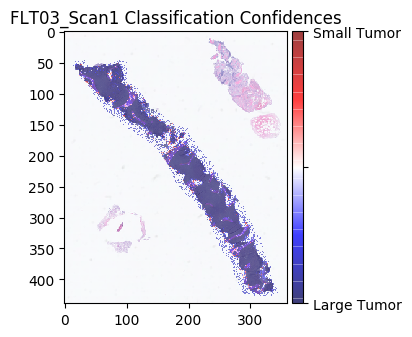

Results for class Large Tumor:
Predicted ratio: 0.96; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.04; True ratio: 0.00; Mean Confidence: 0.09
Results for Slide FLN05_Scan1


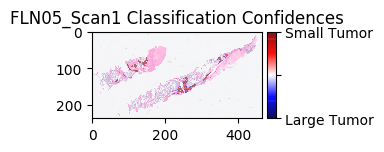

Results for class Large Tumor:
Predicted ratio: 0.21; True ratio: 0.00
Results for class Small Tumor:
Predicted ratio: 0.79; True ratio: 1.00; Mean Confidence: 0.76
Results for Slide FLT02_Scan3


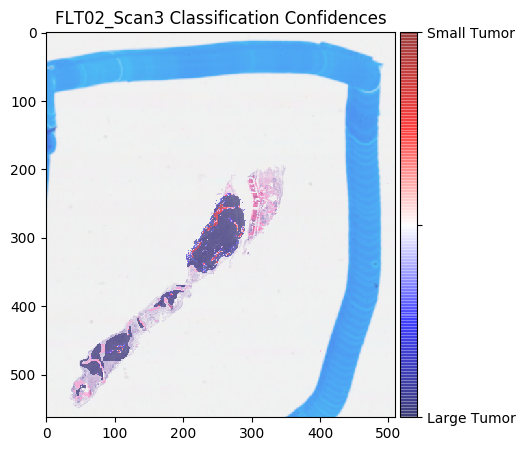

Results for class Large Tumor:
Predicted ratio: 0.93; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.07; True ratio: 0.00; Mean Confidence: 0.09
Results for Slide FLT05_Scan1


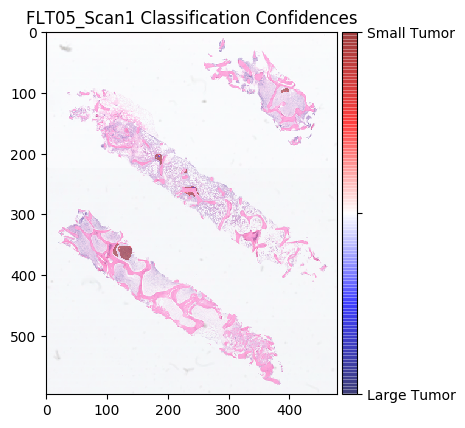

Results for class Large Tumor:
Predicted ratio: 0.03; True ratio: 0.55
Results for class Small Tumor:
Predicted ratio: 0.97; True ratio: 0.45; Mean Confidence: 0.95
Results for Slide FLT04_Scan2


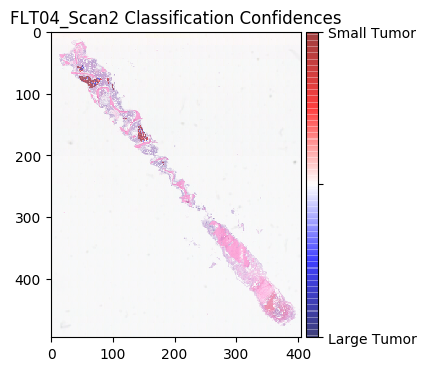

Results for class Large Tumor:
Predicted ratio: 0.17; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.83; True ratio: 0.00; Mean Confidence: 0.78
Results for Slide FLN03_Scan1


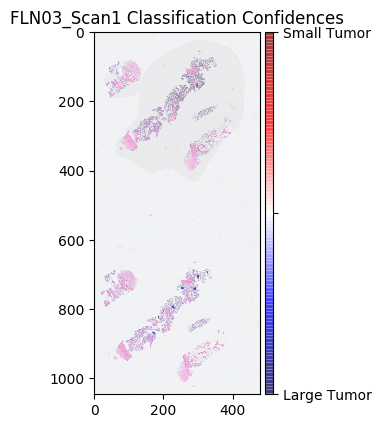

Results for class Large Tumor:
Predicted ratio: 0.91; True ratio: 0.00
Results for class Small Tumor:
Predicted ratio: 0.09; True ratio: 1.00; Mean Confidence: 0.17
Results for Slide FLT14_Scan1


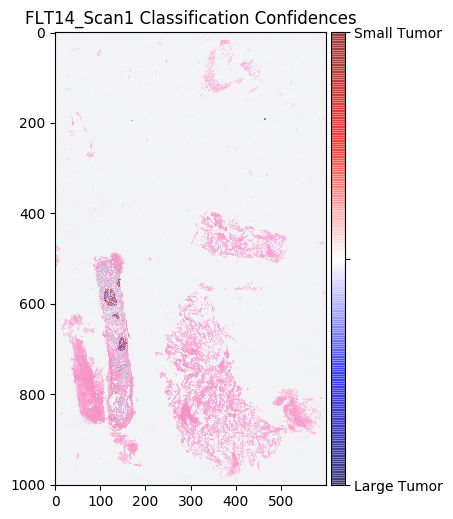

Results for class Large Tumor:
Predicted ratio: 0.30; True ratio: 0.00
Results for class Small Tumor:
Predicted ratio: 0.70; True ratio: 1.00; Mean Confidence: 0.64
Results for Slide FLT09_Scan1


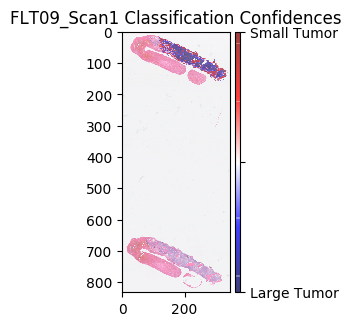

Results for class Large Tumor:
Predicted ratio: 0.64; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.36; True ratio: 0.00; Mean Confidence: 0.38
Results for Slide FLT15_Scan1


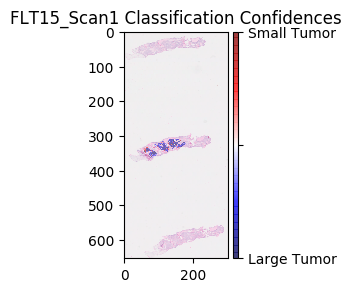

Results for class Large Tumor:
Predicted ratio: 0.82; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.18; True ratio: 0.00; Mean Confidence: 0.27
Results for Slide FLT10_Scan1


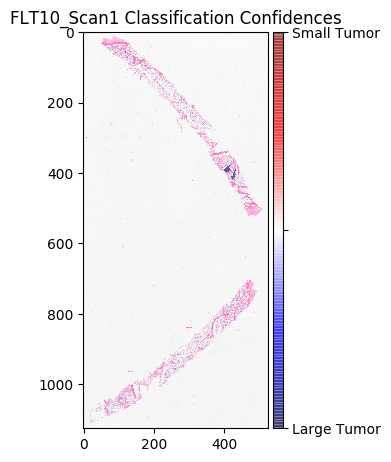

Results for class Large Tumor:
Predicted ratio: 0.99; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.01; True ratio: 0.00; Mean Confidence: 0.04
Results for Slide FLN06_Scan1


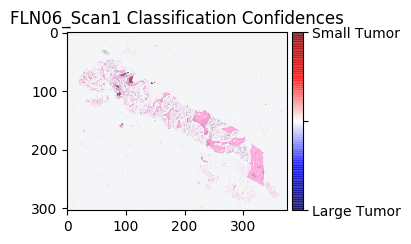

Results for class Large Tumor:
Predicted ratio: 0.01; True ratio: 0.00
Results for class Small Tumor:
Predicted ratio: 0.99; True ratio: 1.00; Mean Confidence: 0.97
Results for Slide FLT13_Scan1


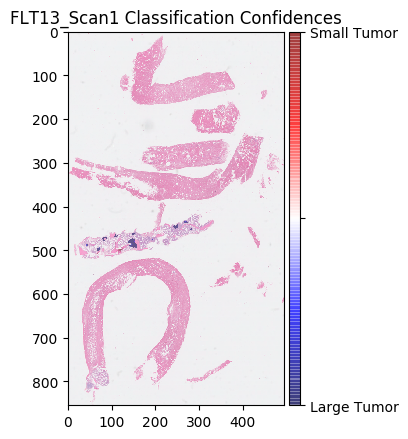

Results for class Large Tumor:
Predicted ratio: 1.00; True ratio: 0.02
Results for Slide FLN01_Scan1


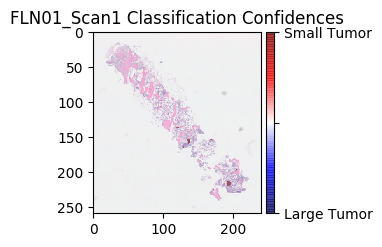

Results for class Large Tumor:
Predicted ratio: 0.00; True ratio: 0.00
Results for class Small Tumor:
Predicted ratio: 1.00; True ratio: 1.00; Mean Confidence: 0.98
Results for Slide FLT07_Scan1


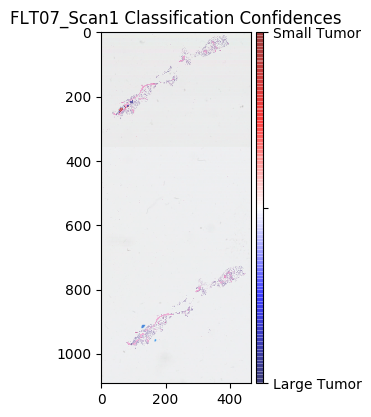

Results for class Large Tumor:
Predicted ratio: 0.50; True ratio: 1.00
Results for class Small Tumor:
Predicted ratio: 0.50; True ratio: 0.00; Mean Confidence: 0.51


In [12]:
process_all_predictions()